tensorflow version: 2.13.0
Time Frame 0/10000 | Active Users: 5 | 0.0%
Current number of users : 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             320       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             12352     
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                20544     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                       

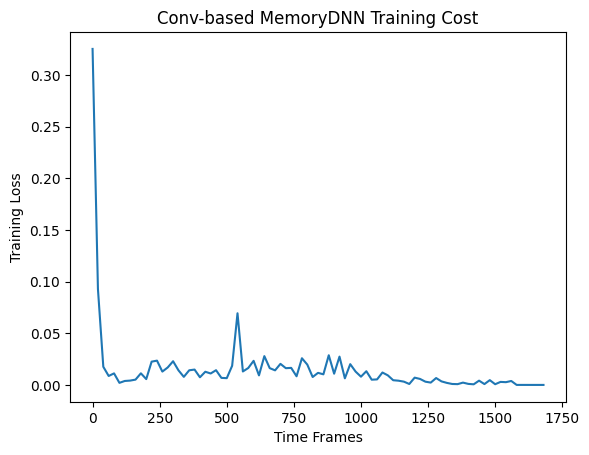

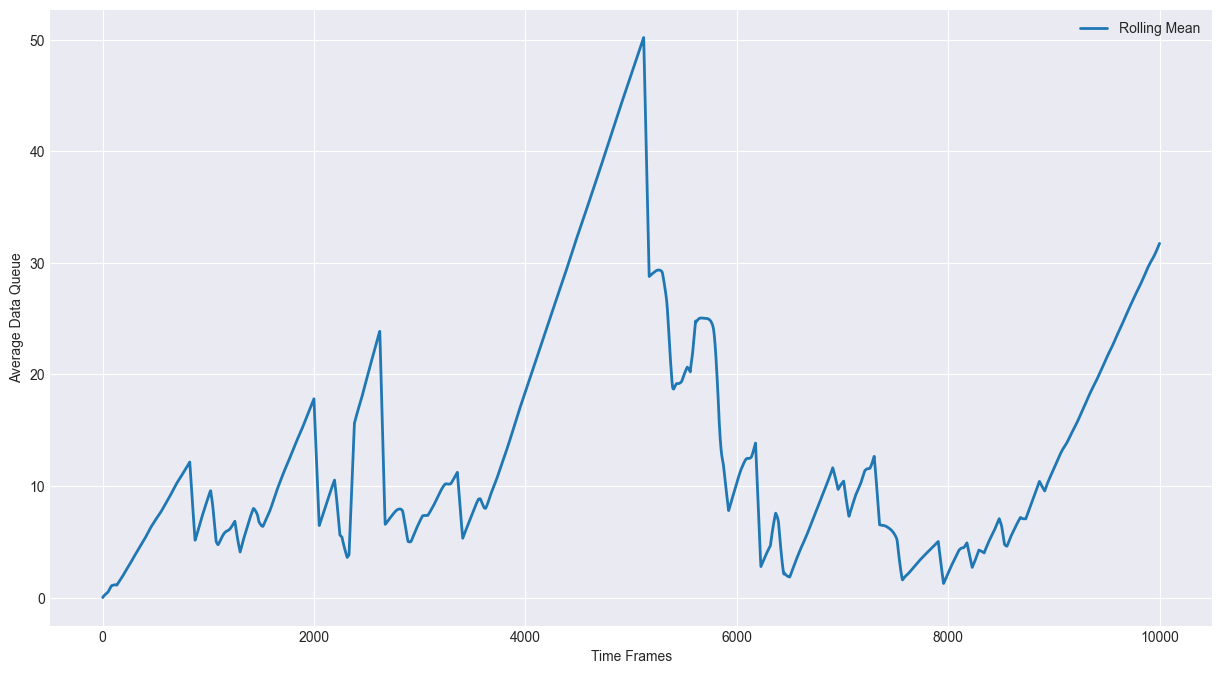

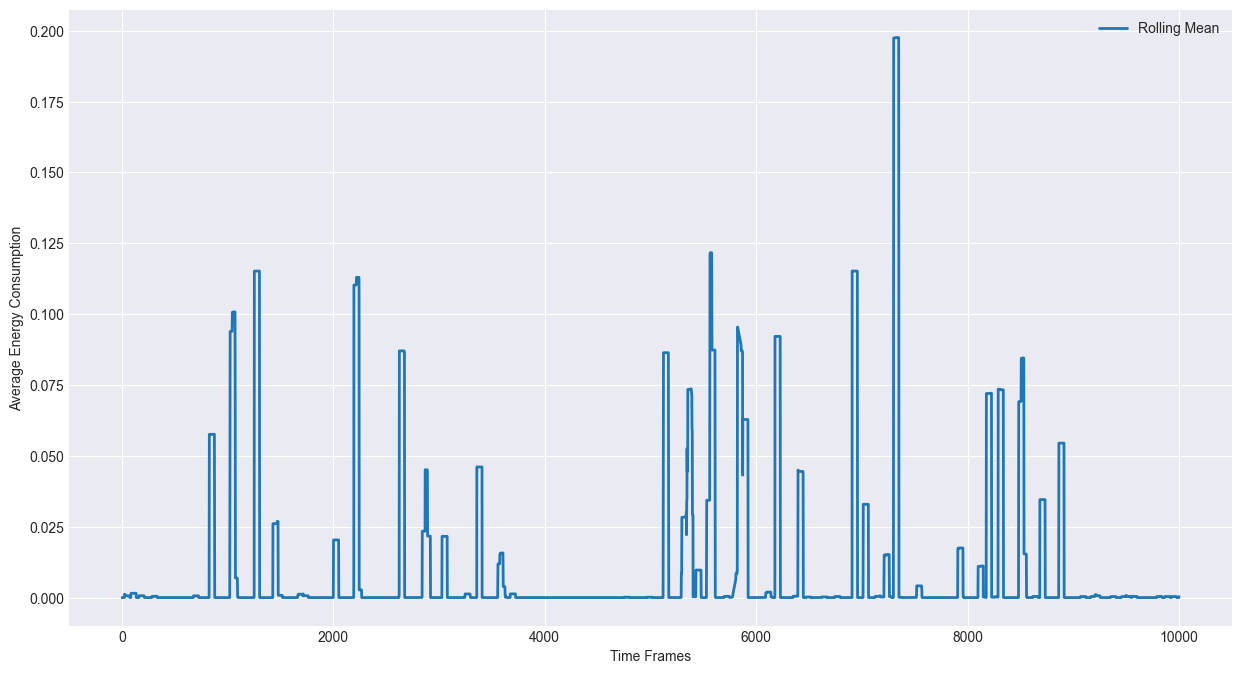

Average time per frame: 0.1926 seconds
Results saved in ./result_base_dynamic_users.mat


In [1]:
# LyDROOwithTF2conv.py
# -*- coding: utf-8 -*-
"""
Base LyDROO simulation using a Conv-based MemoryDNN (TensorFlow 2).
Simulates for various user counts and saves the results, re‑using a single
random user sequence saved to disk.
"""

import os
import scipy.io as sio
import numpy as np
import math
import time
import random
import import_ipynb
from memoryTF2conv import MemoryDNN
from ResourceAllocation import Algo1_NUM

USERS_FILENAME = "user_count_list.npy"

def generate_user_count_sequence(n, min_users, max_users, max_changes):
    change_points = sorted(random.sample(range(1, n), min(max_changes, n - 1)))
    change_points = [0] + change_points + [n]

    user_counts = []
    for i in range(len(change_points) - 1):
        user_value = random.randint(min_users, max_users)
        user_counts.extend([user_value] * (change_points[i + 1] - change_points[i]))
    return np.array(user_counts)

def load_or_create_user_counts(n, min_users, max_users, max_changes, filename=USERS_FILENAME):
    if os.path.exists(filename):
        user_counts = np.load(filename)
    else:
        user_counts = generate_user_count_sequence(n, min_users, max_users, max_changes)
        np.save(filename, user_counts)
    return user_counts

def plot_rate(rate_his, rolling_intv=50, ylabel='Normalized Computation Rate'):
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib as mpl

    rate_array = np.asarray(rate_his)
    df = pd.DataFrame(rate_array)
    mpl.style.use('seaborn-v0_8-darkgrid')

    fig, ax = plt.subplots(figsize=(15, 8))
    plt.plot(
        np.arange(len(rate_array)) + 1,
        np.hstack(df.rolling(rolling_intv, min_periods=1).mean().values),
        linewidth=2,
        label='Rolling Mean'
    )
    plt.ylabel(ylabel)
    plt.xlabel('Time Frames')
    plt.legend()
    plt.grid(True)
    plt.show()

def racian_mec(h, factor):
    n = len(h)
    beta = np.sqrt(h * factor)
    sigma = np.sqrt(h * (1 - factor) / 2)
    x = sigma * np.random.randn(n) + beta
    y = sigma * np.random.randn(n)
    return np.power(x, 2) + np.power(y, 2)

if __name__ == "__main__":
    # Parameters
    n = 10000
    min_users = 5
    N = 30             # maximum user count
    max_changes = 20
    lambda_param = 0.05
    nu = 1000
    Delta = 10
    V = 1.0
    Memory_capacity = 1000
    decoder_mode = 'OP'  # example mode
    CHFACT = 1.0

    # load or create the SAME user sequence
    user_count_list = load_or_create_user_counts(n, min_users, N, max_changes)

    # Initialize arrays for the max user capacity
    channel    = np.zeros((n, N))
    dataA      = np.zeros((n, N))
    Q          = np.zeros((n, N))
    Y          = np.zeros((n, N))
    Obj        = np.zeros(n)
    energy_arr = np.zeros((n, N))
    rate_arr   = np.zeros((n, N))

    # Fixed parameters based on N
    energy_thresh   = np.ones(N) * 0.08
    w               = np.array([1.5 if i % 2 == 0 else 1 for i in range(N)])
    arrival_lambda  = lambda_param * np.ones(N)

    dist_v = np.linspace(start=120, stop=255, num=N)
    Ad, fc = 3, 915e6
    loss_exponent = 3
    light = 3e8
    h0 = np.array([Ad * (light / (4 * math.pi * fc * dist_v[j])) ** loss_exponent for j in range(N)])

    mem = None
    mode_his, k_idx_his = [], []
    start_time = time.time()

    for i in range(n):
        current_N = user_count_list[i]
        if i % (n // 10) == 0:
            print(f"Time Frame {i}/{n} | Active Users: {current_N} | {100 * i / n:.1f}%")

        # update K per your original logic...
        K = current_N
        if i > 0 and i % Delta == 0:
            if Delta > 1:
                recent_k = np.array(k_idx_his[-Delta:-1]) % current_N
                max_k = max(recent_k) + 1
            else:
                max_k = k_idx_his[-1] + 1
            K = min(max_k + 1, current_N)

        h_tmp = racian_mec(h0[:current_N], 0.3)
        h_curr = h_tmp * CHFACT
        channel[i, :current_N] = h_curr
        dataA[i, :current_N]  = np.random.exponential(arrival_lambda[:current_N])

        if i > 0:
            Q[i, :current_N] = Q[i-1, :current_N] + dataA[i-1, :current_N] - rate_arr[i-1, :current_N]
            Q[i, :current_N][Q[i, :current_N] < 0] = 0
            Y[i, :current_N] = np.maximum(
                Y[i-1, :current_N] + (energy_arr[i-1, :current_N] - energy_thresh[:current_N]) * nu,
                0
            )

        nn_input = np.vstack((
            h_curr,
            Q[i, :current_N] / 10000,
            Y[i, :current_N] / 10000
        )).transpose().flatten()

        # Re‑init model if user count changed
        if mem is None or current_N * 3 != mem.net[0]:
            print(f"Current number of users : {current_N}")
            mem = MemoryDNN(
                net=[current_N * 3, 256, 128, current_N],
                learning_rate=0.01,
                training_interval=20,
                batch_size=128,
                memory_size=Memory_capacity
            )

        m_pred, m_list = mem.decode(nn_input, K, decoder_mode)

        r_list, v_list = [], []
        for m in m_list:
            res = Algo1_NUM(m, h_curr, w[:current_N],
                            Q[i, :current_N], Y[i, :current_N],
                            current_N, V)
            r_list.append(res)
            v_list.append(res[0])

        best_idx = np.argmax(v_list)
        k_idx_his.append(best_idx)
        mem.encode(nn_input, m_list[best_idx])
        mode_his.append(m_list[best_idx])

        Obj[i]         = r_list[best_idx][0]
        rate_arr[i, :current_N]   = r_list[best_idx][1]
        energy_arr[i, :current_N] = r_list[best_idx][2]

    total_time = time.time() - start_time
    mem.plot_cost()
    plot_rate(np.sum(Q, axis=1) / user_count_list, rolling_intv=50, ylabel='Average Data Queue')
    plot_rate(np.sum(energy_arr, axis=1) / user_count_list, rolling_intv=50, ylabel='Average Energy Consumption')

    print(f'Average time per frame: {total_time/n:.4f} seconds')

    filename = "./result_base_dynamic_users.mat"
    sio.savemat(filename, {
        'input_h': channel / CHFACT,
        'data_arrival': dataA,
        'data_queue': Q,
        'energy_queue': Y,
        'off_mode': mode_his,
        'rate': rate_arr,
        'energy_consumption': energy_arr,
        'data_rate': rate_arr,
        'objective': Obj,
        'user_count_list': user_count_list
    })
    print(f"Results saved in {filename}")
